# Steerable 3D Spherical Neurons

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
SEED = 239

import numpy as np
np.random.seed(SEED)
np.set_printoptions(precision=4)

import torch
torch.manual_seed(SEED)
if torch.cuda.is_available():
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
import torch.nn as nn
import torch.nn.functional as F 
import torch.optim as optim

import matplotlib.pyplot as plt
import matplotlib.collections as mcol
import matplotlib.transforms as mtransforms

from matplotlib import cm
from mpl_toolkits.mplot3d import Axes3D

from scipy.spatial.transform import Rotation as R
from scipy.special import softmax

from tqdm import tqdm

from models import PointCMLP, SteerableModel

from utils import (get_tetris_data, plot_shapes, score, build_mlgp, 
                   construct_filter_banks, unembed_points, 
                   transform_parameters, build_steerable_model,
                   random_axis_angle, torch_rotation_matrix, entropy)

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
torch.__version__, device

('1.8.1+cu102', device(type='cuda'))

## Creating a steerable spherical classifer
in the following steps:

**Step 1**. Train the ancestor MLGP.

**Step 2**. Transform the hidden unit parameters into filter banks.

**Step 3**. Fix the learned parameters and add the interpolation coefficients $v^k$ as new parameters to fulfill the steerability constraint $\rightarrow$ Steerable spherical classifier.

### Step 1

#### Create the 3D Tetris dataset

In [4]:
Xtrain, Ytrain, shape_names = get_tetris_data()

for shape, name in zip(Xtrain, shape_names):
    print(name, '\n', shape, '\n\n')

chiral_shape_1 
 tensor([[0., 0., 0.],
        [0., 0., 1.],
        [1., 0., 0.],
        [1., 1., 0.]]) 


chiral_shape_2 
 tensor([[ 0.,  0.,  0.],
        [ 0.,  0.,  1.],
        [ 1.,  0.,  0.],
        [ 1., -1.,  0.]]) 


square 
 tensor([[0., 0., 0.],
        [1., 0., 0.],
        [0., 1., 0.],
        [1., 1., 0.]]) 


line 
 tensor([[0., 0., 0.],
        [0., 0., 1.],
        [0., 0., 2.],
        [0., 0., 3.]]) 


corner 
 tensor([[0., 0., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [1., 0., 0.]]) 


L 
 tensor([[0., 0., 0.],
        [0., 0., 1.],
        [0., 0., 2.],
        [0., 1., 0.]]) 


T 
 tensor([[0., 0., 0.],
        [0., 0., 1.],
        [0., 0., 2.],
        [0., 1., 1.]]) 


zigzag 
 tensor([[0., 0., 0.],
        [1., 0., 0.],
        [1., 1., 0.],
        [2., 1., 0.]]) 




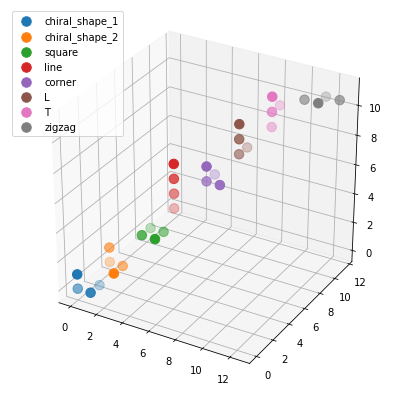

In [5]:
plot_shapes(Xtrain, shape_names, offset=1.5)

#### Train the MLGP on the shapes in the canonical orientation

In [6]:
N_GEOMETRIC_NEURONS = 5
OUTPUT_DIM = len(set(Ytrain.numpy()))

In [7]:
# set the seed here:
torch.manual_seed(SEED)

# instantiate the model:
model = build_mlgp(input_shape=Xtrain.shape[1:], output_dim=OUTPUT_DIM, hidden_layer_sizes=[N_GEOMETRIC_NEURONS], bias=False)

print(model)
print('total number of trainable parameters:', sum([np.prod(p.size()) for p in filter(lambda p: p.requires_grad, model.parameters())]))
print()

model = model.to(device)
Xtrain, Ytrain = Xtrain.float().to(device), Ytrain.to(device)

# define the loss and optimizer:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)

epochs = 2000

# train the model:
for i in range(epochs): 
        y_pred = model(Xtrain)
        loss = criterion(y_pred, Ytrain)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        acc = score(y_pred.detach(), Ytrain)

        if i % 500 == 0:
            print('epoch: %d, loss: %.3f,  acc:  %.3f' % (i, loss.item(), acc))

print('epoch: %d, loss: %.3f,  acc:  %.3f' % (i, loss.item(), acc))


model: MLGP
PointCMLP(
  (hidden_layers): ModuleList(
    (0): Linear(in_features=20, out_features=5, bias=False)
  )
  (out_layer): Linear(in_features=7, out_features=8, bias=False)
)
total number of trainable parameters: 156

epoch: 0, loss: 2.064,  acc:  0.375
epoch: 500, loss: 0.318,  acc:  1.000
epoch: 1000, loss: 0.054,  acc:  1.000
epoch: 1500, loss: 0.019,  acc:  1.000
epoch: 1999, loss: 0.009,  acc:  1.000


### Step 2

The main function in this step is `construct_filter_banks`:
- takes in *non-normalized* (raw) spheres $\tilde{S}_k \in \mathbb{R}^5$, i.e., parameters, extracted from the trained ancestor MLGP model;
- computes the initial rotations $R_O^k$, i.e., from the original sphere centers $c_k$ to (1, 1, 1);
- computes the tetrahedron rotations $R_{Ti}$, i.e., rotations transforming (1, 1, 1) into the other three vertices;
- constructs the filter banks for each sphere as discussed in Section 4 in the paper

\begin{equation*}
	B(\tilde{S}_k) = 
	\begin{bmatrix}
		R_O^{k\top} R_{T0} R_O^{k} \tilde{S}_k \\
		R_O^{k\top} R_{T1} R_O^{k} \tilde{S}_k \\
		R_O^{k\top} R_{T2} R_O^{k} \tilde{S}_k \\ 
		R_O^{k\top} R_{T3} R_O^{k} \tilde{S}_k \\
	\end{bmatrix} ~;
\end{equation*}

- returns an array of $R_O^k$ (optionally) and an array of the constructed $B(\tilde{S}_k)$.

To demonstrate how it works, we first extract the ancestor model hidden layer (i.e., geometric neurons) spheres, and then take one of them to form a filter bank:

In [8]:
# extract the spheres from the ancestor model:
original_state_dict = model.state_dict()

# get the geometric neuron spheres:
hidden_name = 'hidden_layers.0.weight' 
hidden_spheres = original_state_dict[hidden_name]            # (n_geometric_neurons x N_points*5)

# each sphere is a parameter vector of length 5;
# each geometric neuron contains a number of spheres corresponding to the number of input points
# in the point set

# reshape to (n_geometric_neurons x N_points x 5):
hidden_spheres_numpy = hidden_spheres.detach().cpu().numpy().reshape(len(hidden_spheres), -1, 5)
print('hidden_spheres_numpy.shape:', hidden_spheres_numpy.shape) 


# e.g., select the third sphere from the second geometric neuron:
one_sphere = hidden_spheres_numpy[1,2,:]
print('\nS_tilde_k = ', one_sphere)

# construct a filter bank for this sphere:
init_rotation, filter_bank = construct_filter_banks(one_sphere, return_init_rotations=True)
print('\nR_O^k =\n', init_rotation, '\n\nB(S_tilde_k) =\n', filter_bank)

hidden_spheres_numpy.shape: (5, 4, 5)

S_tilde_k =  [-0.6873  0.6743 -0.2568 -0.4767 -0.417 ]

R_O^k =
 [[[ 0.408  -0.6725 -0.6174]
  [ 0.9052  0.2101  0.3693]
  [-0.1187 -0.7096  0.6945]]] 

B(S_tilde_k) =
 [[-0.6873  0.6743 -0.2568 -0.4767 -0.417 ]
 [ 0.2178  0.0995  0.9673 -0.4767 -0.417 ]
 [-0.3543 -0.9161 -0.1682 -0.4767 -0.417 ]
 [ 0.8238  0.1422 -0.5423 -0.4767 -0.417 ]]


#### Visualize

We normalize, i.e., *unembed*, the resulting spheres to get their Euclidean $\mathbb{R}^3$ representation.

By unembedding the 5-vectors, we will get the first three elements that represent the Euclidean coordinates of the sphere center:


the four sphere centers:
 [[ 1.6482 -1.6171  0.6159]
 [-0.5223 -0.2387 -2.3197]
 [ 0.8498  2.1969  0.4033]
 [-1.9756 -0.3411  1.3006]]


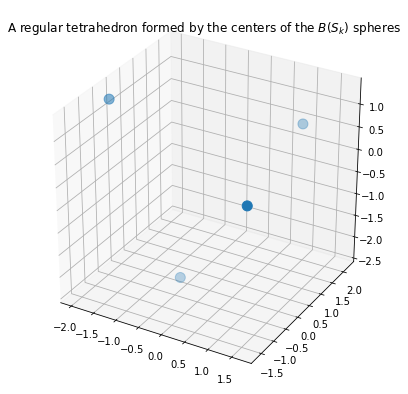

In [9]:
# the centers of the filter bank spheres:
centers = unembed_points(filter_bank)

print('\nthe four sphere centers:\n', centers)
fig = plt.figure(1, figsize=(7,7))
ax = fig.add_subplot(111, projection='3d')         
ax.scatter(centers[:, 0], centers[:, 1], centers[:, 2], s=100)
plt.title('A regular tetrahedron formed by the centers of the $B(S_k)$ spheres')
plt.show()

**Step 2** is wrapped into the function `transform_parameters`: 
- takes in the trained ancestor MLGP model;

- transforms its parameters --- uses the hidden layer spheres to create the filter banks and keeps the output (classification) layer the same;

- returns the initial rotations $R_O^k$, the filter banks $B(\tilde{S}_k)$, and the ancestor model output layer parameters.

In [10]:
transformed_parameters = transform_parameters(model) # used in the experiments further down

### Step 3


**Step 3** is wrapped into the `build_steerable_model` function: 
- creates a steerable model with interpolation coefficients $v^k$ according to the constraint (16) in the paper;

   - since $v^k$ depends on the rotation $R$ applied to the input (see (15) in the paper), we will make the rotation parameters, i.e., three axis-angle parameters, the only free parameters of the model (as discussed in Section 5.2 in the paper);

- the rest of the model parameters are set to be the ones obtained in Step 2 (the filter banks and the unchanged output layer) and are fixed.

In [11]:
# choose initial model parameters:
init_axis_angle = random_axis_angle()

# use the initial parameters and the transformed ancestor model parameters obtained in Step 2
# to build a steerable spherical classifier:
steerable_model = build_steerable_model(input_shape=Xtrain.shape[1:], 
                                        output_dim=OUTPUT_DIM,
                                        hidden_layer_sizes=[N_GEOMETRIC_NEURONS],
                                        init_axis_angle=init_axis_angle,
                                        transformed_parameters=transformed_parameters,
                                        print_hidden_layer_output=False).to(device)
print(steerable_model)
print('total number of free parameters:', \
      sum([np.prod(p.size()) for p in filter(lambda p: p.requires_grad, steerable_model.parameters())]))

print('\ninit_axis_angle:\n', init_axis_angle)
print('\nsteerable_model.axis_angle:\n', steerable_model.axis_angle)

SteerableModel(
  (hidden_layers): ModuleList(
    (0): Linear(in_features=80, out_features=5, bias=False)
  )
  (out_layer): Linear(in_features=7, out_features=8, bias=False)
)
total number of free parameters: 3

init_axis_angle:
 [-0.9549 -0.4905  1.5045]

steerable_model.axis_angle:
 Parameter containing:
tensor([-0.9549, -0.4905,  1.5045], device='cuda:0', dtype=torch.float64,
       requires_grad=True)


## Paper experiments

#### Get the ancestor MLGP activations
(used in the experiments further down)

In [12]:
activation = {}
def get_activation(name):
    def hook(model, input, output):
        activation[name] = output.detach()
    return hook

model.hidden_layers[0].register_forward_hook(get_activation('hidden_layer'))
output = model(Xtrain)

# the ground truth hidden activations -- the ancestor MLGP hidden layer output:
gt_hidden_activations = activation['hidden_layer'].detach().cpu().numpy()

# gt_hidden_activations

### The known rotation experiment (Section 5.3)

In [13]:
np.random.seed(SEED)
torch.manual_seed(SEED)

n_trials = 1000

# the parameter of additive uniform noise to apply to the rotated shapes:
distortions = [0.0, 0.05, 0.1, 0.2, 0.3, 0.5]


init_axis_angles = []
accs = dict()          # classification accuracies for the perturbed rotated shapes
dists = dict()         # L1 distances to the ground truth hidden activations

# the same for the ancestor:
ancestor_accs = dict() 
ancestor_dists = dict()


for distortion in distortions:
    accs[distortion] = []  
    dists[distortion] = [] 
    ancestor_accs[distortion] = [] 
    ancestor_dists[distortion] = [] 
    
    print('\ndistortion:', distortion)
    
    for n in range(n_trials):       
        # construct a random ground truth rotation:
        init_axis_angle = random_axis_angle()
        init_axis_angles.append(init_axis_angle)
        gt_rotation = torch_rotation_matrix(init_axis_angle).to(device).float()

        # rotate the shapes with the ground truth:
        test_data = Xtrain.reshape(-1, 3) @ gt_rotation.T
        test_data = test_data.reshape(Xtrain.shape)
        test_label = Ytrain

        # add uniform noise to the transformed shapes:
        noise = distortion * (2 * torch.rand(test_data.shape).to(device) - 1)
        test_data += noise
        
        # also perturb the input to the ancestor (shape in a canonical orientation):
        ancestor_data = Xtrain + noise

        # construct the steerable model with the initial axis-angle parameters:
        steerable_model = build_steerable_model(input_shape=test_data.shape[1:], 
                                                output_dim=OUTPUT_DIM,
                                                hidden_layer_sizes=[N_GEOMETRIC_NEURONS],
                                                init_axis_angle=init_axis_angle,
                                                transformed_parameters=transformed_parameters,
                                                print_hidden_layer_output=False).to(device)

        # get the model output:
        output = steerable_model(test_data)
        
        # compare to the ancestor:
        ancestor_output = model(ancestor_data)
        
        # compute the model accuracy for the perturbed rotated shapes:
        acc = score(output.detach(), test_label)
        accs[distortion].append(acc)
        
        ancestor_acc = score(ancestor_output.detach(), test_label)
        ancestor_accs[distortion].append(ancestor_acc)
        
        # compute the L1 distance between the hidden activations:
        hidden_activations = steerable_model.hidden_layer_activations.cpu().numpy()
        dist = np.linalg.norm(hidden_activations - gt_hidden_activations, ord=1, axis=1)
        dist = np.mean(dist)
        dists[distortion].append(dist)
        
        ancestor_hidden_activations = model.hidden_layer_activations.cpu().numpy()
        ancestor_dist = np.linalg.norm(ancestor_hidden_activations - gt_hidden_activations, ord=1, axis=1)
        ancestor_dist = np.mean(ancestor_dist)
        ancestor_dists[distortion].append(ancestor_dist)

        # if n % 10 == 0:
            # print('\nexperiment #%d/%d' % (n+1, n_trials))
            # print('\nadditive_uniform_noise:\n', noise)
            # print('\ngt_rotation:\n', gt_rotation)
            # print('\nacc:  %.3f' % acc)
            
    print()
    print('ancestor acc:      %.3f +/- %.3f' % (np.mean(ancestor_accs[distortion]), np.std(ancestor_accs[distortion])))
    print('steerable acc:     %.3f +/- %.3f' % (np.mean(accs[distortion]), np.std(accs[distortion])))
    print()
    print('ancestor L1 dist:  %.3f +/- %.3f' % (np.mean(ancestor_dists[distortion]), np.std(ancestor_dists[distortion])))
    print('steerable L1 dist: %.3f +/- %.3f' % (np.mean(dists[distortion]), np.std(dists[distortion])))
    print(end='\n\n')


distortion: 0.0

ancestor acc:      1.000 +/- 0.000
steerable acc:     1.000 +/- 0.000

ancestor L1 dist:  0.000 +/- 0.000
steerable L1 dist: 0.000 +/- 0.000



distortion: 0.05

ancestor acc:      1.000 +/- 0.000
steerable acc:     1.000 +/- 0.000

ancestor L1 dist:  0.330 +/- 0.047
steerable L1 dist: 0.332 +/- 0.047



distortion: 0.1

ancestor acc:      1.000 +/- 0.000
steerable acc:     1.000 +/- 0.000

ancestor L1 dist:  0.664 +/- 0.095
steerable L1 dist: 0.663 +/- 0.095



distortion: 0.2

ancestor acc:      1.000 +/- 0.000
steerable acc:     1.000 +/- 0.004

ancestor L1 dist:  1.321 +/- 0.188
steerable L1 dist: 1.322 +/- 0.194



distortion: 0.3

ancestor acc:      0.998 +/- 0.016
steerable acc:     0.997 +/- 0.019

ancestor L1 dist:  2.005 +/- 0.291
steerable L1 dist: 2.003 +/- 0.310



distortion: 0.5

ancestor acc:      0.950 +/- 0.079
steerable acc:     0.949 +/- 0.077

ancestor L1 dist:  3.321 +/- 0.480
steerable L1 dist: 3.333 +/- 0.484


